In [1]:
import pandas as pd
import numpy as np

In [11]:
# будем строить модельку для датасета jester-data, содержащего оценки пользователями разных шутеечек

In [20]:
df = pd.read_excel("jester-data-1.xls")

In [21]:
df.head()

,joke_00,joke_01,joke_02,joke_03,joke_04,joke_05,joke_06,joke_07,joke_08,joke_09,...,joke_90,joke_91,joke_92,joke_93,joke_94,joke_95,joke_96,joke_97,joke_98,joke_99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [ ]:
# попробуем алгоритм SVD из библиотеки surprise

In [76]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader

In [61]:
# необходимо привести данные к особому формату, чтобы с ними можно было работать данной библиотекой
# The dataframe containing the ratings. It must have
#         three columns, corresponding to the user (raw) ids, the item
#         (raw) ids, and the ratings, in this order.,

In [65]:
df_pretty = df.stack().reset_index().rename(columns={"level_0":"user_id", "level_1":"joke_id", 0:"rating"})
df_pretty = df_pretty[df_pretty.rating != 99]
df_pretty.head(4)

,user_id,joke_id,rating
0,0,joke_00,-7.82
1,0,joke_01,8.79
2,0,joke_02,-9.66
3,0,joke_03,-8.16


In [68]:
df_pretty.shape

(1810455, 3)

In [72]:
%%time
reader = Reader(rating_scale=(-10, 10))
data = Dataset.load_from_df(df_pretty, reader)

Wall time: 1.96 s


In [77]:
%%time
from surprise import accuracy
from surprise.model_selection import train_test_split

# делим на трэйн/тест
trainset, testset = train_test_split(data, test_size=.25)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 4.1313
Wall time: 2min 22s


4.131284992942079

In [78]:
# попробуем для сравнения алгоритм KNNBasic из той же библиотеки

In [79]:
from surprise import KNNBasic
algo2 = KNNBasic()
algo2.fit(trainset)
predictions = algo2.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 4.2168


4.216787375444213

In [ ]:
# считалось всю ночь а качество немного похуже даже

In [90]:
# предскажем какой-нибудь известный нам рейтинг (факт -7.82)
algo.predict(0,"joke_00")


Prediction(uid=0, iid='joke_00', r_ui=None, est=-7.544009557800309, details={'was_impossible': False})

In [92]:
# а здесь у нас нет факта
algo.predict(0,"joke_99")

Prediction(uid=0, iid='joke_99', r_ui=None, est=-2.1869884947864304, details={'was_impossible': False})

In [108]:
# узнаем, какая шутка зайдет больше всего пользователю 0
user = 0
unseen_list = df.iloc[0][df.iloc[0]==99].index
pd.Series({joke:algo.predict(user,joke).est for joke in unseen_list}).sort_values(ascending=False).head()

joke_88    4.330626
joke_92    1.115877
joke_86    0.115050
joke_79   -0.126740
joke_75   -1.072203
dtype: float64

In [112]:
# Сделаем рекомендательную систему на базе библиотеки LightFM

In [109]:
from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\Asus\Miniconda3\envs\otus_ml\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [110]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm=False, threshold=None):   
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions


In [111]:
interactions = create_interaction_matrix(df = df_pretty,
                                         user_col = 'user_id',
                                         item_col = 'joke_id',
                                         rating_col = 'rating',
                                         norm=True,
                                         threshold = 3)
interactions.shape

(24983, 100)

In [114]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs=4):
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components=n_components, loss=loss, k=k)
    model.fit(x, epochs=epoch, num_threads=n_jobs)
    return model

In [115]:
mf_model = runMF(interactions = interactions,
                 n_components = 30,
                 loss = 'warp',
                 k = 15,
                 epoch = 30,
                 n_jobs = 4)

In [129]:
# Предскажем для нашего пользователя реакцию на пару анекдотов
mf_model.predict([0],[0,99])

array([-0.32533756, -1.90216005])

In [130]:
# любопытсва ради сравним отличия оценок разных систем

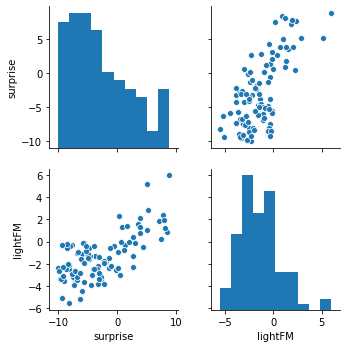

In [151]:
import seaborn as sns
user = 0
sur = [algo.predict(user,joke).est for joke in df.columns]
lfm = mf_model.predict([user], list(range(100)))
sns.pairplot(pd.DataFrame([sur, lfm], index=["surprise","lightFM"]).T);

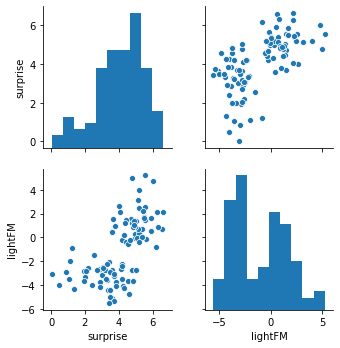

In [150]:
user = 1000
sur = [algo.predict(user,joke).est for joke in df.columns]
lfm = mf_model.predict([user], list(range(100)))
sns.pairplot(pd.DataFrame([sur, lfm], index=["surprise","lightFM"]).T);

In [152]:
# на глазок корреляция есть, но не оценки все-таки очень разные 